In [142]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import util
from test_to_bw_fast import read_model
import metrics
import wandb, os
from test_to_bw_fast import get_config
from tfr_evaluate import get_true_pred, change_resolution
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import h5py
from test_to_bw_fast import open_bw
import numpy as np
from sklearn.metrics import mean_squared_error, mean_squared_log_error 
from tqdm import tqdm
from scipy.spatial import distance
from scipy import stats
import pickle
from test_to_bw_fast import get_config, enforce_constant_size
from metrics import get_pearsonr_per_seq, get_mse, get_js_per_seq, get_poiss_nll
import umap.umap_ as umap
import subprocess
import loss

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# smpl_file = pd.read_csv('merge_idrs/basset_sample_file.tsv', sep='\t', header=None)
# for i, row in smpl_file.iterrows():
#     cell_line, path = row
#     cmd = 'scp {} merge_idrs/ ; gunzip merge_idrs/*.gz'.format(path)
#     process = subprocess.Popen(cmd, shell=True)
#     output, error = process.communicate()
#     new_path = os.path.join('merge_idrs', os.path.basename(path).strip('.gz'))
#     enforce_constant_size(new_path, new_path, 2048, sep='\t')
#     cmd = "bedtools intersect -a  merge_idrs/indexed_sequences.bed -b {} -wa -f 0.75 |uniq > merge_idrs/{}_{}_intersected.bed".format(new_path, i, os.path.basename(path).strip('.bed.gz'))
#     process = subprocess.Popen(cmd, shell=True)
#     output, error = process.communicate()


In [128]:
data_dir = '/home/shush/profile/QuantPred/datasets/chr8/complete/random_chop/i_2048_w_1/'
sts = util.load_stats(data_dir)
testset = util.make_dataset(data_dir, 'test', sts, batch_size=512, shuffle=False)
targets = pd.read_csv(data_dir+'targets.txt', sep='\t')['identifier'].values



In [129]:
run_paths = ['/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar/run-20210920_034502-n8axwb3r',
             '/home/amber/QuantPred/paper_wandb/run-20210922_153851-pkes8nui',
             '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_elzar/*c7k7jwqa'] # 128 poisson basenji


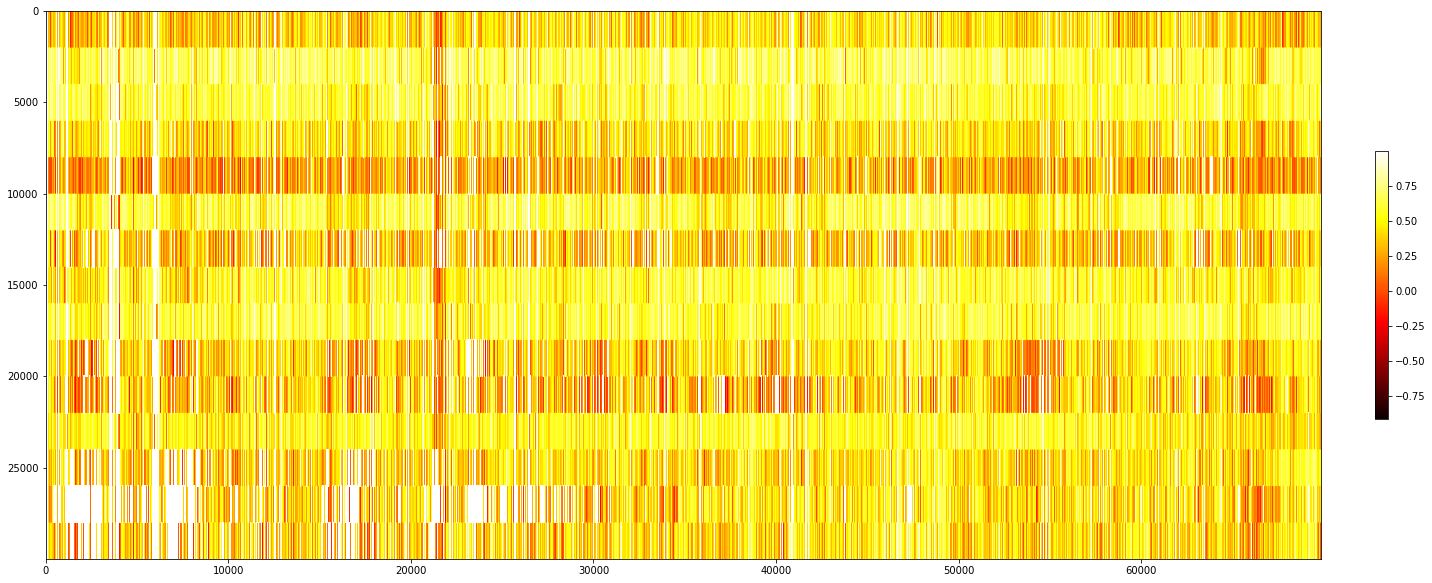

In [74]:
# all_pearsonr = get_pearsonr_per_seq(all_truth, all_pred, take_avg=False)
# all_pearsonr_exp = np.repeat(all_pearsonr, 2000, axis=0)
# plt.subplots(figsize=(20, 200))
# plt.imshow(np.array(all_pearsonr_exp), cmap='hot')
# plt.colorbar(fraction=0.01, pad=0.04)
# plt.tight_layout()

# Across cell lines filtering

In [124]:
runpath_modelid = {}
max_binsize = 0
for run_path in run_paths:
    run_path = glob.glob(run_path)[0]
    config = get_config(run_path)
    model_fn =config['model_fn']['value']
    loss_fn = config['loss_fn']['value']
    bin_size = config['bin_size']['value']
    dataset_type = config['data_dir']['value'].split('/')[-3]
    model_id = '{}_{}_{}_{}'.format(model_fn, loss_fn, (bin_size), dataset_type)
    runpath_modelid[(run_path, bin_size)] = model_id
    if max_binsize < bin_size:
        max_binsize = bin_size

In [125]:
threshold_pearsonr_model_dataframes = []

for (run_path, bin_size_orig), model_id in runpath_modelid.items():
    all_truth, all_pred = [change_resolution(d, bin_size_orig, max_binsize) for d in get_true_pred(run_path, testset)]
    all_pearsonr = np.array(get_pearsonr_per_seq(all_truth, all_pred, take_avg=False)).T
    pearsonrs = []
    thresholds = list(range(25))
    for threshold in thresholds:
        bool_mask_above_threshold = all_truth.max(axis=1)>threshold
        above_threshold_idx = np.unique(np.argwhere(bool_mask_above_threshold).flatten())
        above_threshold_truth = all_truth[above_threshold_idx,:,:]
        pearsonrs.append(np.nanmean(all_pearsonr[above_threshold_idx,:]))
    one_model_result = pd.DataFrame({'threshold': thresholds, 'pearson r': pearsonrs})
    one_model_result['model'] = model_id
    threshold_pearsonr_model_dataframes.append(one_model_result)

137it [00:57,  2.39it/s]
/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


137it [01:51,  1.23it/s]


137it [00:50,  2.69it/s]


<AxesSubplot:xlabel='threshold', ylabel='pearson r'>

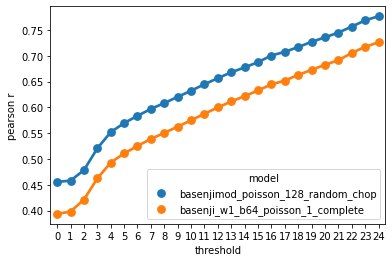

In [119]:
sns.pointplot(data=pd.concat(threshold_pearsonr_model_dataframes), x='threshold', y='pearson r', hue='model')



In [130]:
run_path = run_paths[0]
run_path = glob.glob(run_path)[0]
config = get_config(run_path)
model_fn =config['model_fn']['value']
loss_fn = config['loss_fn']['value']
bin_size = config['bin_size']['value']
dataset_type = config['data_dir']['value'].split('/')[-3]

In [132]:
bin_size

128

In [133]:
all_truth, all_pred = [d for d in get_true_pred(run_path, testset)]
all_pearsonr = np.array(get_pearsonr_per_seq(all_truth, all_pred, take_avg=False)).T


137it [00:56,  2.44it/s]
/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [138]:
all_mse = get_mse(all_truth, all_pred).mean(axis=1)

In [143]:
all_js = get_js_per_seq(all_truth, all_pred)

In [157]:
all_poiss = get_poiss_nll(all_truth, all_pred).mean(axis=1)

In [180]:
mask = np.isfinite(all_pearsonr[:,0])

In [182]:
all_mse[mask,0]

(68609,)

In [159]:
coverage = all_truth[:,:,0].mean(axis=1)

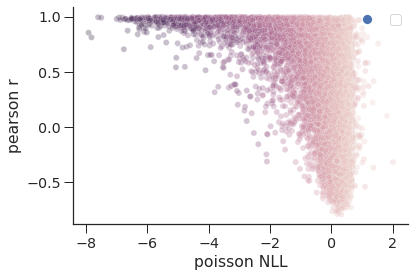

In [252]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
metric1 = ('poisson NLL', all_poiss)
metric2 = ('pearson r', all_pearsonr)
cell_line = 0
df = pd.DataFrame({metric1[0]: metric1[1][mask,cell_line], 
                  metric2[0]: metric2[1][mask,cell_line], 
                  'mean coverage': all_truth[mask,:,cell_line].mean(axis=1)})
sns.scatterplot(data=df, x=metric1[0], y=metric2[0], hue='mean coverage', alpha=0.3)
point = np.argwhere((all_poiss[:,cell_line]>1) & (all_pearsonr[:,cell_line]>0.98))[0][0]
x_point = metric1[1][point, cell_line]
y_point = metric2[1][point, cell_line]
sns.scatterplot(x=[x_point], y=[y_point], color='b', s=100)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend('')



Text(0, 0.5, 'read count')

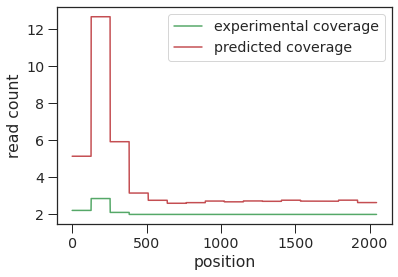

In [246]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.plot(np.repeat(all_truth[point,:,0], 128), c='g', label='experimental coverage')
plt.plot(np.repeat(all_pred[point,:,0], 128), c='r', label='predicted coverage')
plt.legend()
plt.xlabel('position')
plt.ylabel('read count')

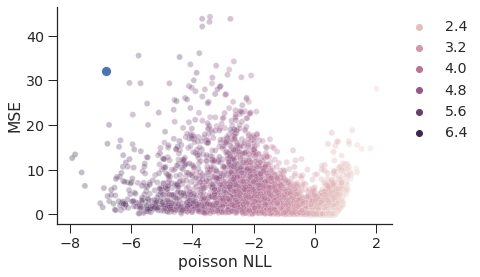

In [255]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
metric1 = ('poisson NLL', all_poiss)
metric2 = ('MSE', all_mse)
cell_line = 0
df = pd.DataFrame({metric1[0]: metric1[1][mask,cell_line], 
                  metric2[0]: metric2[1][mask,cell_line], 
                  'mean coverage': all_truth[mask,:,cell_line].mean(axis=1)})
sns.scatterplot(data=df, x=metric1[0], y=metric2[0], hue='mean coverage', alpha=0.3)

point = np.argwhere((all_poiss[:,0]<-6) & (all_mse[:,0]>30))[0][0]
x_point = metric1[1][point, cell_line]
y_point = metric2[1][point, cell_line]
sns.scatterplot(x=[x_point], y=[y_point], color='b', s=100)


plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.legend(frameon=False, bbox_to_anchor=(1,1))

Text(0, 0.5, 'read count')

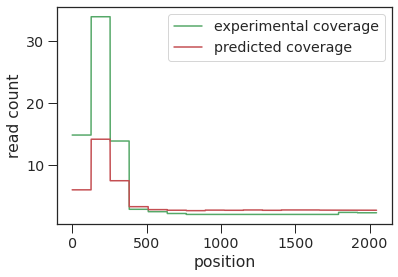

In [256]:
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
plt.plot(np.repeat(all_truth[point,:,0], 128), c='g', label='experimental coverage')
plt.plot(np.repeat(all_pred[point,:,0], 128), c='r', label='predicted coverage')
plt.legend()
plt.xlabel('position')
plt.ylabel('read count')

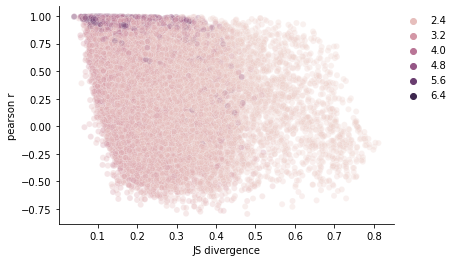

In [192]:
metric1 = ('JS divergence', all_js)
metric2 = ('pearson r', all_pearsonr)
cell_line = 0
df = pd.DataFrame({metric1[0]: metric1[1][mask,cell_line], 
                  metric2[0]: metric2[1][mask,cell_line], 
                  'mean coverage': all_truth[mask,:,cell_line].mean(axis=1)})
sns.scatterplot(data=df, x=metric1[0], y=metric2[0], hue='mean coverage', alpha=0.3)
plt.legend(frameon=False, bbox_to_anchor=(1,1))

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

In [7]:
%%time
thresh_pr_dict = {}
thresh_pos_dict = {}
for thresh in tqdm(range(25)):
    bool_mask = np_y.max(axis=1)>thresh # above threshold in any 1 cell_line
    thresh_inds = np.unique(np.argwhere(bool_mask).flatten())
    filtered_y = np_y[thresh_inds,:,:]
    N_seqs = thresh_inds.shape[0]
    binned_y = filtered_y.reshape(N_seqs, 2048//bin_size, bin_size, len(targets)).mean(axis=2)
    print(binned_y.shape)
#     thresh_pr_dict[thresh] = {}
#     pos_dict = {}
    thresh_pr_dict[thresh] = []
    thresh_pos_dict[thresh] = []
    for cell_line in range(15):
        thresh_pos_dict[thresh].append((filtered_y[:,:,cell_line].max(axis=1)>thresh).sum())
        filtered_x = np_x[thresh_inds,:,:]    
        dataset = tf.data.Dataset.from_tensor_slices(filtered_x)
        dataset = dataset.batch(512)
        pr_dict_same_as_trainset[cell_line] = []
        all_preds = []
        for tensor in dataset:
            P = model(tensor).numpy()
            all_preds.append(P[:,:,cell_line])
        all_preds = np.concatenate(all_preds)
        pr=[]
        for n in range(N_seqs):
            pr.append(stats.pearsonr(binned_y[n, :, cell_line], all_preds[n,:])[0])
        thresh_pr_dict[thresh].append(np.nanmean(pr))
#     thresh_pos_dict[thresh] = pos_dict

  0%|          | 0/25 [00:08<?, ?it/s]


NameError: name 'bin_size' is not defined

In [550]:
pr_df = pd.DataFrame(thresh_pr_dict).T
pos_df = pd.DataFrame(thresh_pos_dict).T



In [574]:
# pr_df.to_csv('pr_df.csv')
# pos_df.to_csv('pos_df.csv')

pr_df = pd.read_csv('pr_df.csv', index_col='Unnamed: 0')
pos_df = pd.read_csv('pos_df.csv', index_col='Unnamed: 0')

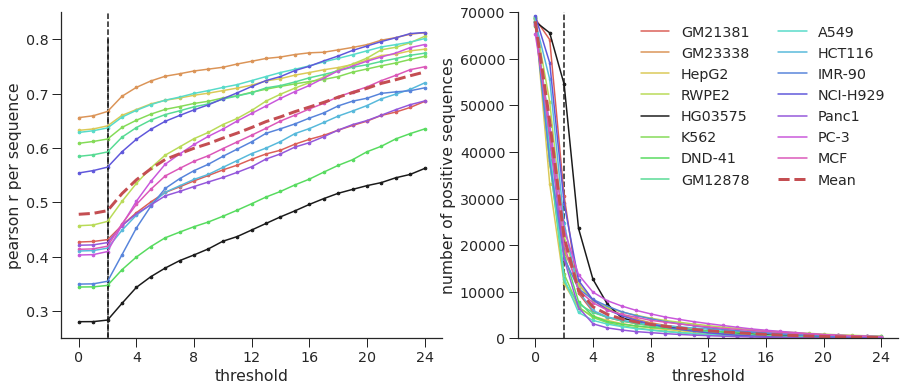

In [595]:
fig, axs = plt.subplots(1,2, figsize=[15,6])
sns.set(font_scale=1.3)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_palette('hls', 15)
for cell_line in range(15):
    for d,df in enumerate([pr_df, pos_df]):
        if cell_line == 4:
            axs[d].plot(range(25), df.iloc[:,cell_line], label = targets[cell_line], c='k')
            axs[d].scatter(range(25), df.iloc[:,cell_line], c='k', s=7)
        else:
            axs[d].plot(range(25), df.iloc[:,cell_line], label = targets[cell_line])
            axs[d].scatter(range(25), df.iloc[:,cell_line], s=7)
axs[0].plot(range(25), pr_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[1].plot(range(25), pos_df.mean(axis=1), linewidth=3, linestyle='--', color='r', label='Mean')
axs[0].vlines(2, 0,0.8, linestyles='--',colors ='k')
axs[0].vlines(2, axs[0].get_ylim()[0], axs[0].get_ylim()[1], linestyles='--',colors ='k')
axs[1].vlines(2, axs[1].get_ylim()[0], axs[1].get_ylim()[1], linestyles='--',colors ='k')
axs[0].set_ylim(0.25,0.85)
axs[1].set_ylim(0,70000)
axs[1].legend(loc="upper right", bbox_to_anchor=(1,1), ncol=2,frameon=False)
axs[0].set_xlabel('threshold')
axs[1].set_xlabel('threshold')
axs[0].set_ylabel('pearson r per sequence')
axs[1].set_ylabel('number of positive sequences')
axs[0].spines['right'].set_visible(False)
axs[0].spines['top'].set_visible(False)
axs[1].spines['right'].set_visible(False)
axs[1].spines['top'].set_visible(False)
axs[0].set_xticks(range(0,n_points,4));
axs[1].set_xticks(range(0,n_points,4));
plt.savefig('thresh_vs_perf_2.svg', bbox_inches='tight')

In [598]:
thresh_pr_dict = {}

for thresh in tqdm([0, 2, 10]):
    bool_mask = np_y.max(axis=1)>thresh # above threshold in any 1 cell_line
    thresh_inds = np.unique(np.argwhere(bool_mask).flatten())
    filtered_y = np_y[thresh_inds,:,:]
    N_seqs = thresh_inds.shape[0]
    binned_y = filtered_y.reshape(N_seqs, 2048//bin_size, bin_size, len(targets)).mean(axis=2)
#     print(binned_y.shape)
    thresh_pr_dict[thresh] = {}
    for cell_line in range(15):
        filtered_x = np_x[thresh_inds,:,:]    
        dataset = tf.data.Dataset.from_tensor_slices(filtered_x)
        dataset = dataset.batch(512)
        thresh_pr_dict[thresh][cell_line] = []
        all_preds = []
        for tensor in dataset:
            P = model(tensor).numpy()
            all_preds.append(P[:,:,cell_line])
        all_preds = np.concatenate(all_preds)
        for n in range(N_seqs):
            thresh_pr_dict[thresh][cell_line].append(stats.pearsonr(binned_y[n, :, cell_line], all_preds[n,:])[0])
     

  0%|          | 0/3 [00:00<?, ?it/s]/home/shush/tf_2/lib/python3.7/site-packages/scipy/stats/stats.py:4023: PearsonRConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(PearsonRConstantInputWarning())
100%|██████████| 3/3 [08:36<00:00, 172.08s/it]


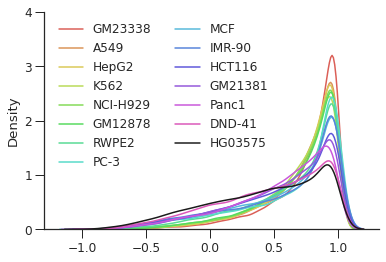

In [602]:
thresh = 10
sns.set(font_scale=1.1)  # crazy big
sns.set_style(style='white')
plt.rcParams['xtick.major.size'] = 9
plt.rcParams['xtick.major.width'] = 1

plt.rcParams['ytick.major.size'] = 9
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True
sns.set_palette('hls', 15)

pearson_r = np.array([np.nanmean(thresh_pr_dict[thresh][k]) for k in range(15)])
the_order = np.argsort(pearson_r)[::-1]


for cell_line in the_order:
#     print(pearson_r[cell_line])
    if targets[cell_line] == 'HG03575':
        sns.kdeplot(thresh_pr_dict[thresh][cell_line],label=targets[cell_line], color='k')
    else:
        sns.kdeplot(thresh_pr_dict[thresh][cell_line],label=targets[cell_line])
plt.legend(loc="upper right", bbox_to_anchor=(0.7,1), ncol=2,frameon=False)
# Hide the right and top spines
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.yticks([0, 1, 2, 3, 4]);
plt.savefig('thresh_vs_pr_kde_{}.svg'.format(thresh))

In [124]:
performance_df = evaluate_per_cell_line(run_path, testset, targets, False)


137it [00:56,  2.43it/s]


In [125]:
cell_line = np.argsort(performance_df['pearson r'].values)[-1]
cell_line_name = performance_df['targets'][cell_line]
cell_line_name
cell_line

8

In [126]:
performance_df

,mse,scaled mse,JS,poisson NLL,pearson r,targets
0,0.564371,0.671935,0.277255,0.821458,0.589191,GM21381
1,0.562127,0.584843,0.259618,0.604392,0.675117,GM23338
2,0.425684,0.43579,0.244894,0.629454,0.642738,HepG2
3,0.950789,0.997083,0.389084,0.640263,0.605639,RWPE2
4,0.963029,1.49211,0.421223,0.855537,0.45385,HG03575
5,0.32181,0.345498,0.213621,0.710241,0.664582,K562
6,0.751968,0.866601,0.466147,0.644947,0.546345,DND-41
7,0.473443,0.515476,0.235337,0.678679,0.630221,GM12878
8,0.29361,0.301459,0.2067,0.714369,0.704757,A549
9,0.672022,0.95761,0.381398,0.68273,0.651836,HCT116


In [127]:
bool_mask = np_y[:,:,cell_line].max(axis=1)>2 # above threshold in the 1 cell_line 
thresh_inds = np.argwhere(bool_mask).flatten()
# thresh_inds = np.unique(np.argwhere(bool_mask)[:,0])

cell_line_name = performance_df['targets'][cell_line]
print(cell_line_name)
idr_seqs = pd.read_csv('merge_idrs/{}_{}_replicate_1_intersected.bed'.format(cell_line, cell_line_name), sep='\t', header=None)
idr_inds = [int(i[-1]) for i in idr_seqs[3].str.split(' ')]

thresh_idr_idx = []
for i in idr_inds:
    thresh_idr_idx.append(np.argwhere(i==thresh_inds).flatten())
thresh_idr_idx = np.concatenate(thresh_idr_idx)
hue_idr_mask = np.zeros(thresh_inds.shape, dtype=bool)
hue_idr_mask[thresh_idr_idx] = True



A549


In [128]:
filtered_x = np_x[thresh_inds,:,:]    
dataset = tf.data.Dataset.from_tensor_slices(filtered_x)
dataset = dataset.batch(128)

intermediate_outputs = []
predictions = []
for tensor in dataset:
    interm = aux_model(tensor).numpy()
    d1, d2, d3 = interm.shape
    intermediate_outputs.append(interm.reshape(d1, d2*d3))
    predictions.append(model(tensor).numpy())
intermediate_outputs = np.concatenate(intermediate_outputs)
predictions = np.concatenate(predictions)



In [129]:
filtered_c = np_c[thresh_inds]

In [130]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(intermediate_outputs)

<AxesSubplot:>

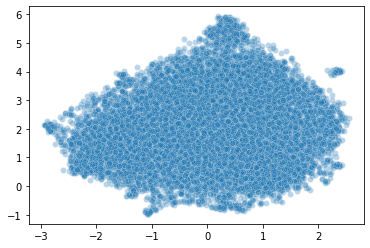

In [131]:
sns.scatterplot(x=embedding[:,1], y=embedding[:,0], alpha=0.3)

In [132]:
color_dict = {False:'cyan',True:'red'}
colors = [color_dict[h] for h in hue_idr_mask]

In [133]:
filtered_y = np_y[thresh_inds,:,:]
N_seqs = filtered_y.shape[0]
pr_list = []
mse_list = []
poiss_list = []
binned_y_list = []
pseudocount = np.finfo(float).eps
for n in range(N_seqs):
    binned_y = filtered_y[n,:,cell_line].reshape(2048//bin_size, bin_size).mean(axis=1)
    binned_y_list.append(binned_y)
    pr_list.append(stats.pearsonr(binned_y, predictions[n,:,cell_line])[0])
    mse_list.append(np_mse(binned_y, 
                           predictions[n,:,cell_line]).mean())
    poiss_list.append((np_poiss(np.log(binned_y+1), 
                      np.log(predictions[n,:,cell_line]+1)).mean()))
    
pr_np = np.array(pr_list)
mse_array = np.array(mse_list)
poiss_array = np.array(poiss_list)

In [134]:
js_array = metrics.get_js_dist(np.array(binned_y_list), predictions[:,:,cell_line])

In [144]:
# hue_idr_mask = np.array(hue_idr_mask, dtype=bool)
summary_df = pd.DataFrame(np.array([embedding[:, 1], embedding[:, 0], 
                                    hue_idr_mask, pr_np, mse_array, 
                                    np.log(mse_array), np.max(binned_y_list, axis=1)]).T,
            columns=['x','y','IDR', 'Pearson r', 'MSE', 'log(MSE)', 'max'])

In [136]:
summary_df['coordinates'] = filtered_c

In [151]:
pr_np

array([0.22939733, 0.2694576 , 0.95357835, ..., 0.64537787, 0.63401873,
       0.88971555])

<AxesSubplot:ylabel='Count'>

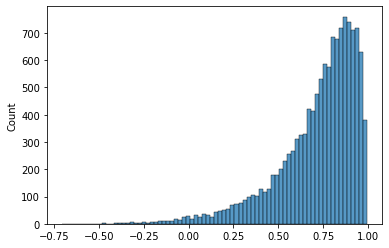

In [149]:
sns.histplot(pr_np)

In [150]:
np.mean(pr_np)

0.7179205727451211

In [80]:
hf = h5py.File('app_data.h5', 'w')
hf.create_dataset('truth', data=binned_y_list)
hf.create_dataset('pred', data=predictions[:,:,cell_line])
hf.close()

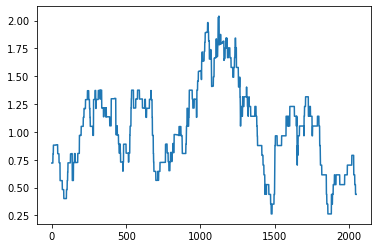

In [138]:
plt.plot(np.repeat(binned_y_list[7455], 1))

In [95]:
summary_df.to_csv('app_summary.csv', index=None)

In [142]:
pr_raw = summary_df['Pearson r'].values
pr_raw[pr_raw<0.8] = 0.8
summary_df['Pearson r'] = pr_raw

In [146]:
summary_df['mean'] = filtered_y[:,:,8].mean(axis=1)
# max_peak = summary_df['mean'].values 
# max_peak[max_peak>8] = 8
# summary_df['mean'] = max_peak

In [400]:
mse_array[mse_array>32] = 32
summary_df['MSE'] = mse_array

<AxesSubplot:xlabel='x', ylabel='y'>

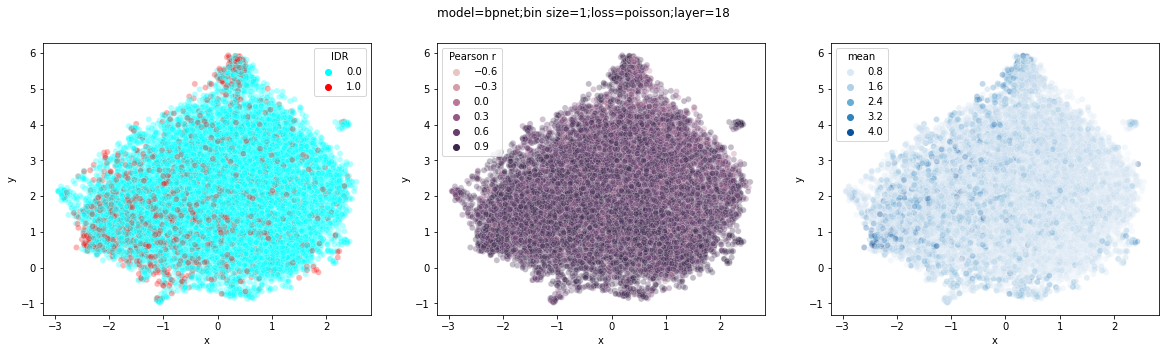

In [148]:
fig, axs = plt.subplots(1, 3, figsize=[20,5]) 
sns.scatterplot(data=summary_df, x='x', y='y', hue='IDR', alpha=0.3, 
                palette=['cyan', 'red'], ax=axs[0])
plt.suptitle('model={};bin size={};loss={};layer={}'.format(model_fn, bin_size, loss_fn, N_LAYER))
sns.scatterplot(data=summary_df, x='x', y='y', hue='Pearson r', alpha=0.3, 
                ax=axs[1], vmin=0, vmax=2)
# sns.scatterplot(data=summary_df, x='x', y='y', hue='max', alpha=0.3, 
#                 ax=axs[2], palette='Reds')
sns.scatterplot(data=summary_df, x='x', y='y', hue='mean', alpha=0.3, 
                ax=axs[2], palette='Blues')

In [42]:
DATA_DF = pd.read_csv('app_summary.csv')

In [43]:
DATA_DF

,x,y,IDR,Pearson r,MSE,log(MSE),max,binned coverage,prediction
0,1.338018,0.814940,0.0,0.300127,0.206778,-1.576107,1.571873,[0.11959648 0.34825993 0.4705696 0.916029 1...,"[0.4941203, 0.8588787, 0.4745626, 0.67877877, ..."
1,7.199457,4.499838,1.0,0.490517,2.136578,0.759205,3.956306,[0.0332098 0.85225964 3.9563065 2.6850204 1...,"[0.48674902, 0.53621674, 0.6054562, 1.1438228,..."
2,3.547815,-3.695535,0.0,0.991840,2.875977,1.056393,5.826645,[5.826645 3.370038 0.28138828 0.2038908 0...,"[1.686771, 0.9834859, 0.12664409, 0.10166829, ..."
3,3.296240,7.119222,1.0,0.960964,1.410399,0.343872,11.356232,[ 0.39894772 3.0013618 5.7546387 11.356232...,"[0.4173242, 2.8270788, 6.897782, 8.945327, 5.4..."
4,3.742683,5.215945,0.0,0.703213,0.459671,-0.777244,3.524376,[1.4107609 0.9307022 1.6492939 3.524376 1...,"[0.676343, 0.72347164, 0.9873507, 2.1649883, 1..."
...,...,...,...,...,...,...,...,...,...
12813,0.652195,-1.888278,0.0,-0.886345,0.726788,-0.319120,1.760540,[0.6182966 0.83708 1.0898991 1.76054 1.340...,"[0.9206804, 1.0614226, 0.4541691, 0.1330057, 0..."
12814,1.009854,-1.654478,0.0,0.682228,0.518436,-0.656938,2.186626,[0.32811785 0.31061387 0.12283516 0.05905128 1...,"[0.494048, 0.31312454, 0.26735178, 0.19782281,..."
12815,3.749233,-0.794406,0.0,0.727289,2.338965,0.849709,2.664074,[2.3889923 2.664074 1.776844 2.394741 2.440...,"[0.4223247, 0.90810263, 0.5323118, 0.6227283, ..."
12816,4.765223,-3.624241,0.0,0.697353,0.083585,-2.481886,1.001034,[0. 0.10035801 0.10518837 0.19260788 0...,"[0.06604997, 0.08400752, 0.14744568, 0.1229937..."


In [372]:
data_dir = '/home/shush/profile/QuantPred/datasets/chr8/complete/random_chop/i_2048_w_1/'
sts = util.load_stats(data_dir)
testset_no_c = util.make_dataset(data_dir, 'test', sts, coords=False, batch_size=512, shuffle=False)
run_path = '/mnt/31dac31c-c4e2-4704-97bd-0788af37c5eb/shush/wandb/wandb_bizon/run-20210706_102343-vlazubgf'
performance_df = evaluate_per_cell_line(run_path, testset_no_c, targets, False, False)

137it [00:46,  2.96it/s]


In [373]:
performance_df

,mse,scaled mse,JS,poisson NLL,pearson r,targets
0,0.507141,0.491304,0.228383,0.755236,0.601824,GM21381
1,0.496757,0.491435,0.215701,0.791044,0.694031,GM23338
2,0.377824,0.376902,0.204101,0.841401,0.661475,HepG2
3,0.843394,0.834701,0.330217,0.772139,0.620752,RWPE2
4,0.845184,0.806147,0.360112,0.736651,0.473902,HG03575
5,0.289988,0.287684,0.178143,0.832707,0.673132,K562
6,0.659688,0.641758,0.403396,0.861363,0.570803,DND-41
7,0.436881,0.433048,0.194736,0.835927,0.631666,GM12878
8,0.269623,0.26653,0.172375,0.813728,0.71145,A549
9,0.617555,0.603096,0.321039,0.805368,0.654856,HCT116
